# 貓狗辨識 - L4評估模型
本次的課程將學習如何實作二元分類的模型，目的是利用圖片當中的特徵，來預測是貓或狗，藉由此項專案將學會如何使用python裡的套件pandas和numpy來操作資料、並利用來搭建深度學習的模型，特別是用於圖像辨識的卷積神經網絡。

### 課程架構
在貓狗辨識的專案中，將帶著學員建構一個深度學習的模型，並進行貓狗預測，主要包括下面四個步驟：

>1.   如何進行資料前處理(Processing)

>2.   如何實作資料增強(Data Augmentation)

>3.   如何建構深度學習模型(Model)

>4.   如何評估其模型的學習狀況(Inference) 

## 連結Drive與Colab
在執行本範例前請先確認Jupyter筆記本設置是否正確，首先點選主選單的「修改」─「筆記本設置」─「運行類別」，選擇「Python3」，同時將「硬件加速器」下拉式選單由「None」改成「GPU」，再按「保存」。

In [1]:
# 4-1
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
# 如果出現了長條型的可輸入單元格 代表你曾經 授權過了 可以直接跳到下一格

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 131183 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.13-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.13-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.13-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [0]:
# 4-2
# 指定Google Drive雲端硬盤的根目錄，名為drive
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
# 4-3
# 在drive下面新增一個Colab Notebook的資料夾
import os
os.chdir("drive")
if("Colab Notebooks" in os.listdir()):
  os.chdir("Colab Notebooks")
else:
  os.mkdir("Colab Notebooks")
  os.chdir("Colab Notebooks")

## import library與讀取檔案

In [1]:
# 4-4
# 首先載入所需套件，一般會利用import (package_name) as (xxx) 來簡化套件名稱，使得之後呼叫它們時更方便

# 操作陣列型態資料處理的套件
import pandas as pd
import numpy as np

# 資料檔案處理
import os # 處理字符串路徑
import zipfile # 內建標準庫提供做壓縮與解壓縮用

# 資料視覺化
import matplotlib.pyplot as plt # 基本的繪圖套件
import matplotlib.image as mpimg # 用於讀取圖片
%matplotlib inline
plt.style.use('ggplot') # 製圖時選用ggplot的視覺樣式

# 指定模型學習的參數
import random
import time
seed = 7
np.random.seed(seed)

# 忽略警告
import warnings
warnings.filterwarnings('ignore')

In [2]:
# 4-5
# keras
from keras.models import Model
from keras import layers
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense,Flatten,Dropout # Frequency Layers
from keras.layers.convolutional import Conv2D,MaxPooling2D,Convolution2D # CNN Layers
from keras.utils.np_utils import to_categorical # 資料夾輸出標籤
from keras.preprocessing.image import img_to_array, load_img
from keras.preprocessing.image import ImageDataGenerator # 從資料夾生成訓練用資料集

# tensorflow
import tensorflow as tf

Using TensorFlow backend.


In [3]:
# 4-6
# 使用wget指令，可從連結中下載檔案至指定位置
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip # 若要指定下載檔案儲存在硬碟中的檔名，可以使用 -O 參數

# 將下載到的資料集解壓縮至資料夾中
local_zip = '/tmp/cats_and_dogs_filtered.zip' # 把載下的資料帶入local_zip
zip_ref = zipfile.ZipFile(local_zip, 'r') # 讀取資料夾中的資料
zip_ref.extractall('/tmp') # 解壓縮的目的路徑
zip_ref.close() # 關閉資料夾

# 取得資料集路徑
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train') #連結目錄與文件名
validation_dir = os.path.join(base_dir, 'validation')

--2020-02-26 16:30:33--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 216.58.200.48
Connecting to storage.googleapis.com (storage.googleapis.com)|216.58.200.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  5.31MB/s    in 12s     

2020-02-26 16:30:46 (5.53 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [4]:
# 4-7
# 取得所有圖片的路徑
train_cats_dir = os.path.join(train_dir, 'cats')           # 取得訓練用貓圖片的路徑
train_dogs_dir = os.path.join(train_dir, 'dogs')           # 取得訓練用狗圖片的路徑
validation_cats_dir = os.path.join(validation_dir, 'cats') # 取得驗證用貓圖片的路徑
validation_dogs_dir = os.path.join(validation_dir, 'dogs') # 取得驗證用狗圖片的路徑

In [5]:
# 4-8
# 取得所有訓練及驗證用的圖片
train_cat_fnames = os.listdir(train_cats_dir)              # 取得訓練用所有貓圖片
train_dog_fnames = os.listdir(train_dogs_dir)              # 取得訓練用所有狗圖片
validation_cat_fnames = os.listdir(validation_cats_dir)    # 取得驗證用所有貓圖片
validation_dog_fnames = os.listdir(validation_dogs_dir)    # 取得驗用所有狗圖片

## 4.1 卷積網路模型
為了讓大家更容易了解如何利用TensorFlow及Keras建構一個深度學習模型，這裡展示了一個小型的卷積神經網路(Convolution Neural Network, CNN)，共有三層卷積層(包含ReLu及Max Pooling)，每個卷積層皆用3x3的濾波器進行卷積動作，三層分別提取16, 32及64組濾波器。接著展開成獨立節點後，再加入二層全連結層，分別為512及1個節點，而最後得到的那一個節點加上Sigmodid函數即為最終輸出的結果。其值介於0.0 ~ 1.0，當值越接近1.0時圖片為狗的機率越高，反之輸出值越接近0.0時圖片判定是貓的機率越高。

這個模型雖然不大，但可適用各種圖像分類問題，大家可試著導入自己準備的圖像進行測試。

## 4.2 輸入圖像尺寸正規化
接著說明輸入(層)資料問題。由於資料集的每張圖片大小、長寬比都不一樣，這樣無法直接進入訓練模型，因此須將影像尺寸統一縮小到指定尺寸。在這個範例中會將圖片統一縮至150x150像素，而色彩依然保持全彩(RGB 3通道)，所以對輸入層來說等於150x150x3。至於影像縮小後造成影像變形導致訓練結果有些許不同的問題是另一層次問題，在此先忽略不予考慮。

## 4.3 模型架構及訓練參數說明

In [6]:
# 4-9
# 以Sequential Model來設計模型架構
model = Sequential()

# 第一層-卷積層
# Conv2D共產生16組3X3X3的濾波器，並搭配ReLu激活(Activation)函數
# 以2x2窗口進行最大池化(Max Pooling)動作，取出四個值中最大值，同時將圖像縮小至一半尺寸74x74x16
# 輸入的圖像格式為(150x150x3) : 150x150是圖片的像素, 3的話則為顏色的通道 R, G, B
# 每一組濾波器另加上一個偏置值(Bias)一起訓練，故共有 (3x3x3+1)x16=448個參數待訓練，經過卷積後圖像大小變成148x148x16
model.add(Conv2D(16,(3,3),strides=(1,1),input_shape=(150, 150, 3),padding='valid',activation='relu',kernel_initializer='uniform'))
model.add(MaxPooling2D(pool_size=(2,2),strides=None))

# 第二層-卷積層
# Conv2D共產生32組3X3X3的濾波器，並搭配ReLu激活(Activation)函數
# 每一組濾波器另加上一個偏置值(Bias)一起訓練，故共有 (3x3x16+1)x32=4,640個參數待訓練，經過卷積後圖像大小變成72x72x32
# 接著同樣以2x2窗口進行最大池化(Max Pooling)動作，取出四個值中最大值，同時將圖像縮小至一半尺寸36x36x32
model.add(Conv2D(32,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='uniform'))
model.add(MaxPooling2D(pool_size=(2,2),strides=None))

# 第三層-卷積層
# Conv2D共產生64組3X3X3的濾波器，並搭配ReLu激活(Activation)函數
# 每一組濾波器另加上一個偏置值(Bias)一起訓練，故共有 (3x3x32+1)x64=18,496個參數待訓練，經過卷積後圖像大小變成34x34x64
# 以2x2窗口進行最大池化(Max Pooling)動作，取出四個值中最大值，同時將圖像縮小至一半尺寸17x17x64
model.add(Conv2D(64,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='uniform'))
model.add(MaxPooling2D(pool_size=(2,2),strides=None))

# 第四層-平坦層
# 將所有節點展開(Flatten)變成一維節點，準備進行下一階段的全連結網路，共有17x17x64=18,496個節點
model.add(Flatten())

# 第五層-全連結層
# 以512個節點和上一層進行全連結(Dense)，並搭配ReLu激活函數
# 加入Dropout層，避免訓練發生過擬合
# 再加上一個偏置值(Bias)一起訓練，故共有(18,496+1)x512=9,470,464個參數待訓練
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
          
# 展示模型結構及各層所需訓練參數，合計共有10,641,441個參數待訓練
model.summary()

AttributeError: module 'tensorflow' has no attribute 'get_default_graph'

## 4.4 模型配置及訓練優化設定
接下來配置模型訓練的規格。這裡用binary_crossentropy損失來訓練模型，因為這個範例是一個二元分類問題，而最終激活函數是sigmoid。 而優化器部份使用rmsprop自動學習速率調速，學習速率初始為0.001。 在訓練期間，需監控分類的準確性。

補充說明一下，使用RMSprop優化算法優於隨機梯度下降（SGD），因為RMSprop為我們實現了自動學習速率調整。而其它如Adam和Adagrad等優化器也會在訓練期間自動調整學習速率，若使用在本範例亦可以很好地工作。

In [11]:
# 4-10
from keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['acc'])

print('rmsprop自動學習速率調速設置！done！')



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
rmsprop自動學習速率調速設置！done！


## 4.5 設置數據產生器

In [0]:
# 4-11
# 以ImageDataGenerator模組，將圖片中每像素的數值介於[0,255] (int整數)
# 正規化(rescale)到 [0,1]之間，即所有資料都乘上1.0/255，以利後續計算
train_datagen = ImageDataGenerator(rescale=1./255) # 為訓練資料
test_datagen = ImageDataGenerator(rescale=1./255) # 為驗證資料

## 4.6 設置數據壓縮

In [13]:
# 4-12
# 使用置數據產生器的flow_from_directory方法，將讀取源文件夾中的圖片，並標註標籤(路徑名稱）輸入到模型(網路)中
train_generator = train_datagen.flow_from_directory(
        train_dir,  # 圖片訓練集來源
        target_size=(150, 150),  # 指定圖片尺寸縮小至150x150
        batch_size=20, # 批量大小一次讀取20張圖片
        class_mode='binary') # 分類方式為二進制(非0即1)

validation_generator = test_datagen.flow_from_directory(
        validation_dir, # 圖片驗證集來源
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

print('resize！done!')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
resize！done!


## 4.7 訓練模型
一開始不用設定太多次，主要先確認每次迭代是否有令正確率(Accuracy)是否有逐漸提高，在執行過程中，每次迭代會輸出訓練的損失率(loss)；通常正常率不一定每次都向上升(損失率下降)，有時會產生振盪(忽高忽低)，這是正常的，只要有逐漸收歛(高低變動幅度趨近零)即可。

若想再將正確率提高些，一般來說可增加迭代次數

In [14]:
# 4-13
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,  # 2000 images = batch_size * steps
      epochs=15,
      validation_data=validation_generator,
      validation_steps=50,  # 1000 images = batch_size * steps
      verbose=2)

Epoch 1/15
 - 64s - loss: 0.7031 - acc: 0.5160 - val_loss: 0.6902 - val_acc: 0.5340
Epoch 2/15
 - 62s - loss: 0.7002 - acc: 0.5400 - val_loss: 0.6966 - val_acc: 0.4960
Epoch 3/15
 - 63s - loss: 0.6891 - acc: 0.5570 - val_loss: 0.6870 - val_acc: 0.5360
Epoch 4/15
 - 63s - loss: 0.6876 - acc: 0.6230 - val_loss: 0.7381 - val_acc: 0.5540
Epoch 5/15
 - 63s - loss: 0.6314 - acc: 0.6670 - val_loss: 0.6319 - val_acc: 0.6450
Epoch 6/15
 - 63s - loss: 0.6046 - acc: 0.7060 - val_loss: 0.5952 - val_acc: 0.6900
Epoch 7/15
 - 63s - loss: 0.5478 - acc: 0.7245 - val_loss: 0.5977 - val_acc: 0.7010
Epoch 8/15
 - 63s - loss: 0.4903 - acc: 0.7645 - val_loss: 0.5781 - val_acc: 0.7170
Epoch 9/15
 - 63s - loss: 0.4480 - acc: 0.7895 - val_loss: 0.6403 - val_acc: 0.7080
Epoch 10/15
 - 63s - loss: 0.3962 - acc: 0.8205 - val_loss: 0.6442 - val_acc: 0.7090
Epoch 11/15
 - 63s - loss: 0.3408 - acc: 0.8410 - val_loss: 0.6513 - val_acc: 0.6930
Epoch 12/15
 - 62s - loss: 0.2815 - acc: 0.8755 - val_loss: 1.0400 - val_a

## 4.7 評估模型

Text(0.5, 1.0, 'Training and validation loss')

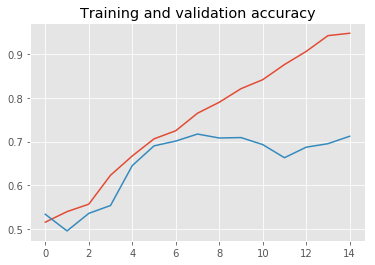

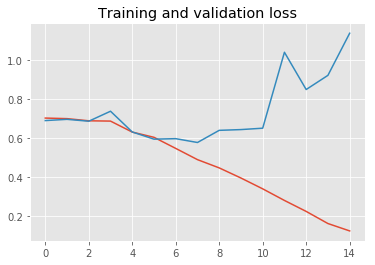

In [15]:
# 4-14
# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

Result = 0.000834
Test time :0.043943 second.
有 0.08% 機率為資料集2


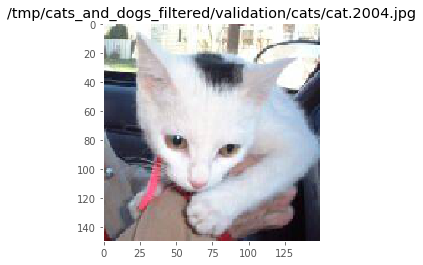

In [16]:
# 4-15
# 隨機從img_files_1或img_files_2路徑挑選一個
validation = '/tmp/cats_and_dogs_filtered/validation'

img_files_1 = [os.path.join(validation_cats_dir, f) for f in validation_cat_fnames]
img_files_2 = [os.path.join(validation_dogs_dir, f) for f in validation_dog_fnames]
img_path = random.choice(img_files_1 + img_files_2)

# 讀入待測試圖像並秀出
img = load_img(img_path, target_size=(150, 150))  # this is a PIL image
plt.title(img_path)
plt.grid(False)
plt.imshow(img)

# 將圖像轉成模型可分析格式(150x150x3, float32)
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)
x /= 255 # Rescale by 1/255

start = time.time() # 啟動計時器
result = model.predict(x) # 對輸入圖像進行推論(預測)
finish = time.time() # 結束計時器

print ("Result = %f" %result) # 印出結果可能機率值(0.0 ~ 1.0)
print("Test time :%f second." %(finish-start)) # 印出推論時間

# 設定分類門檻值並印出推論結果
print("有 %.2f%% 機率為資料集2" %(result * 100)) # 印出推論時間

----